<a href="https://colab.research.google.com/github/maxi9113/colab_notebook/blob/main/Taller_Aproximaci%C3%B3n_Funcional_Forecasting_MLP_Algorith.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En el procesamiento de bebidas, la aplicación de un determinado conservante es
realizada en función de la combinación de 4 variables reales, definidas por x1 (cantidad
de agua), x2 (grado de acidez), x3 (temperatura) y x4 (tensión superficial). Se sabe, que
solo existen tres tipos de conservantes que pueden ser aplicados, los cuales son
categorizados como A, B y C. A partir de estas variables, se realizan pruebas de
laboratorio para determinar que tipo de conservante debe ser aplicado en determinada
bebida.

De 148 pruebas experimentales, un equipo de expertos decide aplicar una red MLP
como clasificador de patrones, con el fin de que esta identifique que conservante será
aplicado en un determinado lote de bebida. Por las características de la línea de
producción, se utilizará una red con tres salidas


Arquitectura de la red


*   4 Entradas
*   1 capa escodida 15 Neuronas
*   3 Salidas









In [98]:
import pandas as pd

# Leer el archivo CSV en un DataFrame de pandas, usando ';' como separador
X_Data = pd.read_csv('/content/time_series.csv', sep=';')


# Mostrar las primeras filas del DataFrame para verificar la carga
display(X_Data.head())

,Sample,f(t)
0,1,0.1701
1,2,0.1023
2,3,0.4405
3,4,0.3609
4,5,0.7192


In [99]:
import numpy as np

# Separar las columnas de entrada (x1 a x4) y salida (d1 a d3)

x_time_series = X_Data[['f(t)']].replace(',', '.', regex=True).astype(float).values

# Mostrar las formas de los arrays para verificar
print("Shape of x_train:", x_time_series.shape)





Shape of x_train: (100, 1)


Ejecute cinco entrenamientos para la red MLP mostrada en la figura, por medio
del algoritmode aprendizaje backpropagation, inicializando todas las matrices
de pesos con valores aleatorios entre 0 y 1.

In [100]:
import time
import numpy as np
import matplotlib.pyplot as plt

# 1. Definir la función de activación y su derivada
def f_activate(x):
    return sigmoidal(x)

def f_derivative(x):
    return sigmoidal_derivative(x)

def sigmoidal(x):
    return 1 / (1 + np.exp(-x))

def sigmoidal_derivative(x):
    return x * (1 - x)

def tanh(x): return np.tanh(x)
def tanh_derivative(y): return 1 - y**2

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

# --- NUEVA FUNCIÓN: Crear ventanas de contexto para la TDNN ---
def create_tdnn_context_windows(data, context_window):
    """
    Crea ventanas de contexto para los datos de entrada de una TDNN.

    Args:
        data (np.array): Datos de entrada en formato (num_timesteps, num_features).
        context_window (int): Número de pasos de tiempo a incluir en cada ventana (incluyendo el actual).
                              Ej: si context_window=3, se usan [t, t-1, t-2].

    Returns:
        np.array: Datos con ventanas de contexto, formato (num_samples_tdnn, num_features * context_window).
                  Las primeras (context_window - 1) muestras serán 'rellenadas' con ceros o replicadas
                  para mantener la misma longitud de salida si se desea, o simplemente se descartan.
                  Aquí, rellenaremos con ceros y ajustaremos las etiquetas en consecuencia.
    """
    num_timesteps, num_features = data.shape
    if context_window <= 0:
        raise ValueError("context_window debe ser un entero positivo.")

    # El número de muestras resultantes será num_timesteps - (context_window - 1)
    # Por ejemplo, si context_window=3, la primera muestra válida es para t=2,
    # usando [t=2, t=1, t=0].
    # Para simplificar, asumiremos que las primeras (context_window - 1) muestras
    # no tendrán un contexto completo y las rellenaremos o las ignoraremos.
    # En este ejemplo, las vamos a rellenar con ceros para tener una salida del mismo tamaño
    # que la entrada original, ajustando las etiquetas en la función de entrenamiento.

    # Una forma más sencilla para el entrenamiento es simplemente crear las ventanas
    # para las muestras donde el contexto completo esté disponible.
    # Esto significa que el número de muestras de salida será num_timesteps - (context_window - 1).

    tdnn_inputs = []
    for t in range(context_window - 1, num_timesteps):
        # Concatenar las ventanas de tiempo
        window = data[t - (context_window - 1) : t + 1].flatten()
        tdnn_inputs.append(window)

    return np.array(tdnn_inputs)


X_tdnn = create_tdnn_context_windows(x_time_series, 3)




In [159]:
def train_tdnn(X_seq, y_seq, hidden_layer_sizes, context_window,
               epochs=100000, learning_rate=0.1, momentum=0.0,
               precision_rate=1e-6, max_epoch=100000, seed=1, name=""):
    import time
    import numpy as np

    start = time.time()
    np.random.seed(None)

    # --- Preprocesamiento de entradas ---
    X_tdnn = create_tdnn_context_windows(X_seq, context_window)
    y_tdnn = y_seq[context_window - 1:]

    input_neurons_per_timestep = X_seq.shape[1]
    input_neurons_tdnn = input_neurons_per_timestep * context_window
    output_neurons = y_tdnn.shape[1]

    weights, biases = [], []
    layer_sizes = [input_neurons_tdnn] + hidden_layer_sizes + [output_neurons]

    print(f"Arquitectura TDNN: {layer_sizes[0]} -> {' -> '.join(map(str, hidden_layer_sizes))} -> {layer_sizes[-1]}")
    print(f"Ventana de contexto: {context_window}")

    # Inicialización de pesos y sesgos
    for i in range(len(layer_sizes) - 1):
        w = np.random.uniform(-1, 1, (layer_sizes[i], layer_sizes[i+1]))
        b = np.random.uniform(-0.5, 0.5, (1, layer_sizes[i+1]))
        weights.append(w)
        biases.append(b)

    # Inicializa acumuladores de momentum
    prev_weight_updates = [np.zeros_like(w) for w in weights]
    prev_bias_updates = [np.zeros_like(b) for b in biases]

    loss_history, epoch_history = [], []
    epoch = 0

    # === Entrenamiento ===
    while True:
        # Forward Propagation
        layer_outputs = [X_tdnn]
        for i in range(len(weights)):
            current_input = layer_outputs[-1]
            layer_input_weighted = np.dot(current_input, weights[i]) + biases[i]
            layer_output = f_activate(layer_input_weighted)
            layer_outputs.append(layer_output)

        predicted_output = layer_outputs[-1]

        # Backpropagation
        errors = [None] * len(weights)
        deltas = [None] * len(weights)
        error = y_tdnn - predicted_output
        errors[-1] = error
        deltas[-1] = error * f_derivative(predicted_output)

        for i in range(len(weights) - 2, -1, -1):
            error_current_layer = deltas[i+1].dot(weights[i+1].T)
            errors[i] = error_current_layer
            deltas[i] = error_current_layer * f_derivative(layer_outputs[i+1])

        # Actualización con Momentum
        for i in range(len(weights)):
            grad_w = layer_outputs[i].T.dot(deltas[i])
            grad_b = np.sum(deltas[i], axis=0, keepdims=True)

            weight_update = learning_rate * grad_w + momentum * prev_weight_updates[i]
            bias_update = learning_rate * grad_b + momentum * prev_bias_updates[i]

            weights[i] += weight_update
            biases[i] += bias_update

            prev_weight_updates[i] = weight_update
            prev_bias_updates[i] = bias_update

        # Cálculo del error
        loss = np.mean(np.abs(error))
        epoch += 1

        if epoch % 10000 == 0:
            print(f"Época {epoch}, Error medio: {loss:.6f}")

        loss_history.append(loss)
        epoch_history.append(epoch)

        # Condición de parada
        if loss <= precision_rate or epoch >= max_epoch:
            print(f"✅ Entrenamiento detenido en epoch {epoch} con Loss: {loss:.6f}")
            end = time.time()
            print(f"Tiempo transcurrido: {end - start:.3f} segundos")
            return weights, biases, epoch_history, loss_history, context_window, name


In [160]:
# Lista para almacenar las configuraciones de cada TDNN
tdnn_configs = []

# --- Configuración para TDNN-1 ---
config_tdnn_1 = {
    "id" : 0,
    "name": "TDNN-1",
    "hidden_layers": [10],           # n1 = 10
    "context_window_size": 3,        # p = 05
    "learning_rate": 0.01,
    "epochs": 200000,
    "precision_rate": 0.5e-6,
    "seed": None # Puedes variar la semilla si quieres experimentos diferentes
}
tdnn_configs.append(config_tdnn_1)

# --- Configuración para TDNN-2 ---
config_tdnn_2 = {
    "id" : 1,
    "name": "TDNN-2",
    "hidden_layers": [15],           # n1 = 15
    "context_window_size": 2,       # p = 10
    "learning_rate": 0.01,
    "epochs": 200000,
    "precision_rate": 0.5e-6,
    "seed": None
}
tdnn_configs.append(config_tdnn_2)

# --- Configuración para TDNN-3 ---
config_tdnn_3 = {
    "id" : 2,
    "name": "TDNN-3",
    "hidden_layers": [25],           # n1 = 25
    "context_window_size": 5,       # p = 15
    "learning_rate": 0.01,
    "epochs": 200000,
    "precision_rate": 0.5e-6,
    "seed": None
}
tdnn_configs.append(config_tdnn_3)

 Execute 3 training routines for each candidate network, initializing the weight
matrices (in each training process) with appropriate random values. If necessary,
update the random number generator in each training process so that the initial
elements are different on each routine. Use the logistic activation function
(sigmoid) for all neurons, with the learning rate value {η} equal to 0.1,
momentum factor {a} equal to 0.8, and precision {e} equal to 0.5 10−6

In [161]:
trained_values = []
training_histories = []

# Ejecutar 3 veces por cada configuración
for config in tdnn_configs:
    for run in range(3):
        print(f"\n🚀 Entrenando {config['name']} (ejecución {run + 1}/3)")

        weights_tdnn, biases_tdnn, epoch_hist_tdnn, loss_hist_tdnn, context_window, name = train_tdnn(
            x_time_series[:-1], x_time_series[1:],
            hidden_layer_sizes=config['hidden_layers'],
            context_window=config['context_window_size'],
            epochs=config['epochs'],
            learning_rate=config['learning_rate'],
            momentum=0.8,
            precision_rate=config['precision_rate'],
            max_epoch=config['epochs'],
            seed=config['seed'],   # puedes variar la semilla si quieres
            name=f"{config['name']}_T{run + 1}"
        )

        trained_values.append({
            "name": f"{config['name']}_T{run + 1}",
            "id" :f"{config['id']}{run}",
            "weights": weights_tdnn,
            "biases": biases_tdnn,
            "context_window": context_window
        })

        training_histories.append({
            "name": f"{config['name']}_T{run + 1}",
            "id" :f"{config['id']}{run}",
            "epochs": epoch_hist_tdnn,
            "loss": loss_hist_tdnn
        })



🚀 Entrenando TDNN-1 (ejecución 1/3)
Arquitectura TDNN: 3 -> 10 -> 1
Ventana de contexto: 3
Época 10000, Error medio: 0.072254
Época 20000, Error medio: 0.051437
Época 30000, Error medio: 0.041894
Época 40000, Error medio: 0.034427
Época 50000, Error medio: 0.027110
Época 60000, Error medio: 0.023205
Época 70000, Error medio: 0.023195
Época 80000, Error medio: 0.023155
Época 90000, Error medio: 0.022941
Época 100000, Error medio: 0.022753
Época 110000, Error medio: 0.022576
Época 120000, Error medio: 0.022434
Época 130000, Error medio: 0.022299
Época 140000, Error medio: 0.022183
Época 150000, Error medio: 0.022077
Época 160000, Error medio: 0.021963
Época 170000, Error medio: 0.021865
Época 180000, Error medio: 0.021773
Época 190000, Error medio: 0.021712
Época 200000, Error medio: 0.021677
✅ Entrenamiento detenido en epoch 200000 con Loss: 0.021677
Tiempo transcurrido: 21.567 segundos

🚀 Entrenando TDNN-1 (ejecución 2/3)
Arquitectura TDNN: 3 -> 10 -> 1
Ventana de contexto: 3
Época 10

Register the results of each training routine in Table 5.6.

In [169]:
import pandas as pd

# Convertir a dataframe expandido
df = pd.DataFrame([
    {"name": h["name"], "epoch": e, "loss": l}
    for h in training_histories
    for e, l in zip(h["epochs"], h["loss"])
])

# Agrupar por id, y obtener el mínimo de loss y el máximo de epoch
summary_df = df.groupby("name").agg(
    Em=("loss", "min"),
    Epochs=("epoch", "max")
).reset_index()

print(summary_df)


        name        Em  Epochs
0  TDNN-1_T1  0.021677  200000
1  TDNN-1_T2  0.031037  200000
2  TDNN-1_T3  0.021722  200000
3  TDNN-2_T1  0.151158  200000
4  TDNN-2_T2  0.151189  200000
5  TDNN-2_T3  0.157348  200000
6  TDNN-3_T1  0.006473  200000
7  TDNN-3_T2  0.007401  200000
8  TDNN-3_T3  0.008318  200000


In [170]:
import numpy as np

def predict_future_tdnn(x_time_series, context_window, weights, biases, t):
    """
    Predice los próximos t pasos de una serie temporal usando una TDNN entrenada.
    """

    # Asegurar que sea vector plano
    if x_time_series.ndim > 1:
        x_time_series = x_time_series.flatten()

    context = x_time_series[-context_window:].copy()
    predictions = []

    for _ in range(t):
        output = context.copy()
        print(f"{_}{output}")
        for i in range(len(weights)):
            output = f_activate(np.dot(output, weights[i]) + biases[i])
        pred = output.item()
        predictions.append(pred)
        # Mover ventana
        context = np.roll(context, -1)
        context[-1] = pred

    return np.array(predictions)


In [171]:
from IPython.display import display, HTML

# Graficar los resultados
predictions_by_model = {}

for i, model in enumerate(trained_values):
    name = model["name"]
    model_id = model["id"]
    weights_tdnn = model["weights"]
    biases_tdnn = model["biases"]
    context_window = model["context_window"]

    print(f"✅ Predicción {i+1} | Modelo: {name} | ID: {model_id} | Contexto: {context_window}")

    future_steps = 20  # predecir 20 valores futuros
    predictions = predict_future_tdnn(
        x_time_series=x_time_series,
        context_window=context_window,
        weights=weights_tdnn,
        biases=biases_tdnn,
        t=future_steps
    )

    predictions_by_model[name] = predictions
    print(f"Predicciones de {name} generadas. Forma: {predictions.shape}")


✅ Predicción 1 | Modelo: TDNN-1_T1 | ID: 00 | Contexto: 3
0[0.0924 0.7984 0.0077]
1[0.7984     0.0077     0.33587618]
2[0.0077     0.33587618 0.000489  ]
3[3.35876177e-01 4.88999461e-04 6.15139172e-01]
4[4.88999461e-04 6.15139172e-01 1.52359200e-01]
5[0.61513917 0.1523592  0.5376488 ]
6[0.1523592 0.5376488 0.2232411]
7[0.5376488 0.2232411 0.8492413]
8[0.2232411  0.8492413  0.02732116]
9[0.8492413  0.02732116 0.31727929]
10[2.73211604e-02 3.17279292e-01 2.74818013e-04]
11[3.17279292e-01 2.74818013e-04 6.37196207e-01]
12[2.74818013e-04 6.37196207e-01 1.90418657e-01]
13[0.63719621 0.19041866 0.43498771]
14[0.19041866 0.43498771 0.25685589]
15[0.43498771 0.25685589 0.95883612]
16[0.25685589 0.95883612 0.10721325]
17[0.95883612 0.10721325 0.44560704]
18[0.10721325 0.44560704 0.00053532]
19[0.44560704 0.00053532 0.20976681]
Predicciones de TDNN-1_T1 generadas. Forma: (20,)
✅ Predicción 2 | Modelo: TDNN-1_T2 | ID: 01 | Contexto: 3
0[0.0924 0.7984 0.0077]
1[0.7984     0.0077     0.37751644]
2[

 For all training routines executed in item 2, perform the validation of candidate
networks using the test set provided in Table 5.7. Compute for each training process the mean relative error between the desired values and the values
produced by the network, for all test samples. Also, compute the respective
variance.

In [172]:
import pandas as pd
import numpy as np

# Leer el archivo CSV en un DataFrame de pandas, usando ';' como separador
X_Data_Predictions = pd.read_csv('/content/time_series_predictions.csv', sep=';')
# Mostrar las primeras filas del DataFrame para verificar la carga
x_predictions = X_Data_Predictions['x(t)'].replace(',', '.', regex=True).astype(float).values

# Mostrar las formas de los arrays para verificar
print("Shape of x_train:", x_predictions.shape)

display(X_Data_Predictions.head())




Shape of x_train: (20,)


,index,x(t)
0,101,0.4173
1,102,0.0062
2,103,0.3387
3,104,0.1886
4,105,0.7418


In [185]:
# Agregar las columnas de predicción a X_Data_Predictions
for name, predictions in predictions_by_model.items():
    for i in range(len(predictions)):
        X_Data_Predictions.at[i, f'{name}'] = predictions[i]
  # Mostrar el DataFrame modificado
display(HTML(X_Data_Predictions.head(20).to_html(index=False)))

index,x(t),TDNN-1_T1,TDNN-1_T2,TDNN-1_T3,TDNN-2_T1,TDNN-2_T2,TDNN-2_T3,TDNN-3_T1,TDNN-3_T2,TDNN-3_T3
101,0.4173,0.335876,0.377516,0.339864,0.399232,0.404970,0.400580,0.428099,0.423664,0.426805
102,0.0062,0.000489,0.023231,0.003017,0.117582,0.122776,0.127398,0.004876,0.001169,0.000476
103,0.3387,0.615139,0.557841,0.582224,0.445689,0.456064,0.457683,0.337553,0.351679,0.339227
104,0.1886,0.152359,0.061662,0.151436,0.180421,0.169148,0.213079,0.196205,0.156106,0.171739
105,0.7418,0.537649,0.682430,0.594659,0.464860,0.464264,0.441360,0.731080,0.737194,0.749253
106,0.3138,0.223241,0.009460,0.112950,0.255477,0.217274,0.287865,0.340279,0.315667,0.335314
107,0.4466,0.849241,0.413010,0.455414,0.464421,0.467433,0.434457,0.435403,0.447910,0.439444
108,0.0835,0.027321,0.032382,0.100255,0.343237,0.276126,0.341113,0.095011,0.088796,0.101543
109,0.1930,0.317279,0.623973,0.698952,0.450942,0.467064,0.423795,0.181833,0.199366,0.176820
110,0.3807,0.000275,0.044358,0.086457,0.408160,0.348248,0.373401,0.427877,0.362609,0.476245


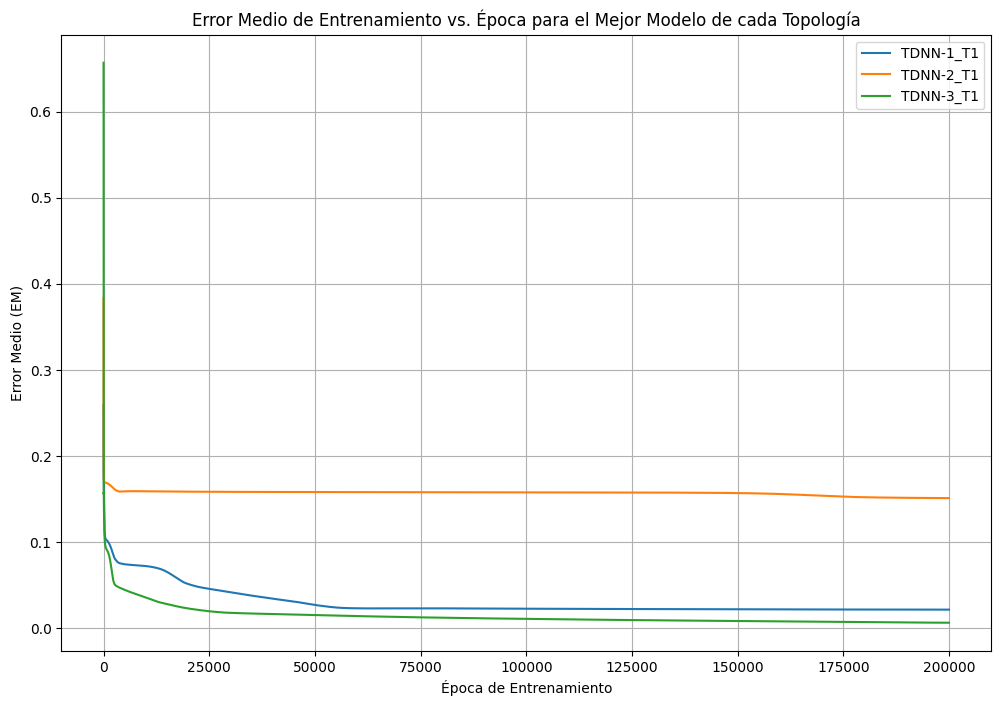

In [186]:
import matplotlib.pyplot as plt
import numpy as np

# Encuentra el mejor modelo (menor EM) para cada topología (TDNN-1, TDNN-2, TDNN-3)
best_models_by_topology = {}
for config in tdnn_configs:
    topology_name = config["name"]
    best_loss = float('inf')
    best_model_history = None

    for history in training_histories:
        if history["name"].startswith(topology_name):
            min_loss_this_run = np.min(history["loss"])
            if min_loss_this_run < best_loss:
                best_loss = min_loss_this_run
                best_model_history = history

    if best_model_history:
        best_models_by_topology[topology_name] = best_model_history

# Graficar el error medio (EM) para cada mejor modelo
plt.figure(figsize=(12, 8))

for topology_name, history in best_models_by_topology.items():
    plt.plot(history["epochs"], history["loss"], label=history["name"])

plt.xlabel("Época de Entrenamiento")
plt.ylabel("Error Medio (EM)")
plt.title("Error Medio de Entrenamiento vs. Época para el Mejor Modelo de cada Topología")
plt.legend()
plt.grid(True)
plt.show()

TDNN-1_T1
TDNN-2_T1
TDNN-3_T1


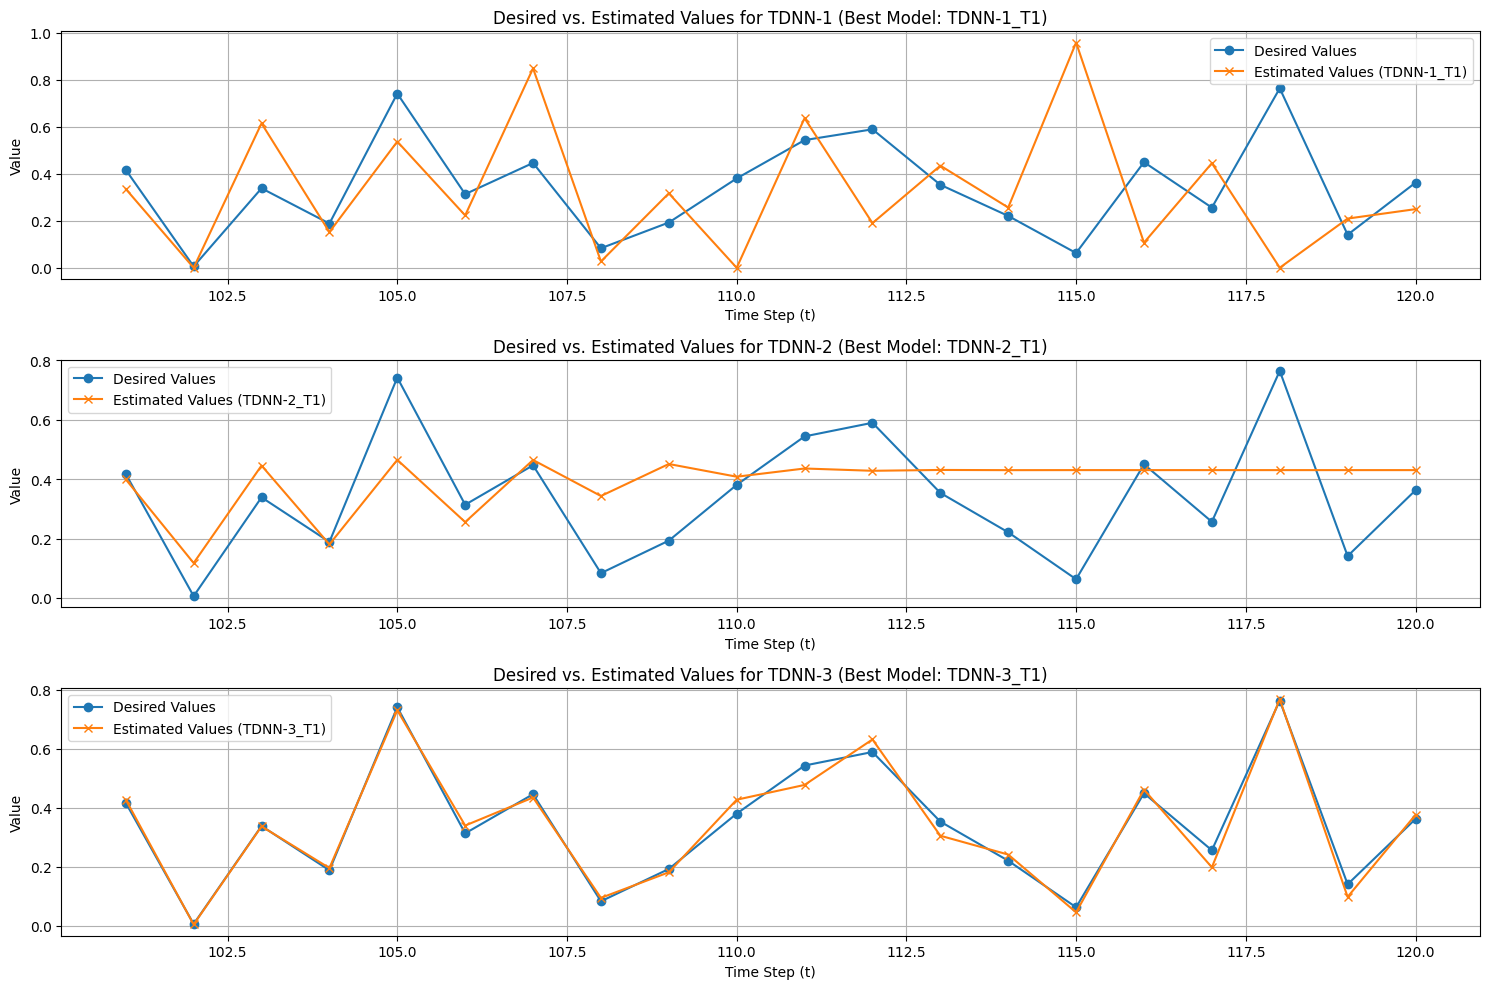

In [196]:
import matplotlib.pyplot as plt

# Find the best model name for each topology based on minimum EM
best_model_names = {}
for topology_name, history in best_models_by_topology.items():
    best_model_names[topology_name] = history["name"]

# Plot the desired values and estimated values for the test set
plt.figure(figsize=(15, 10))


for i, (topology_name, model_name) in enumerate(best_model_names.items()):
    print(model_name)
    plt.subplot(len(best_model_names), 1, i + 1)
    plt.plot(X_Data_Predictions['index'], X_Data_Predictions['x(t)'], label='Desired Values', marker='o')
    plt.plot(X_Data_Predictions['index'], X_Data_Predictions[f'{model_name}'], label=f'Estimated Values ({model_name})', marker='x')
    plt.xlabel("Time Step (t)")
    plt.ylabel("Value")
    plt.title(f"Desired vs. Estimated Values for {topology_name} (Best Model: {model_name})")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()